# 4D Sleipner seismic inversion (surveys 1994 and 2001)

In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from pylops import BlockDiag, Identity, HStack, VStack, Laplacian, FirstDerivative, Zero
from pylops.avo.poststack import PoststackLinearModelling
from pylops.basicoperators import Block
from pyproximal.proximal import L21, L2
from pyproximal.optimization.segmentation import PrimalDual
from pylops.optimization.leastsquares import regularized_inversion as RegularizedInversion
from prox4d.jointinv4D import jis_4D
from prox4d.utils_ import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
b = np.load('../data/Sleipner/Sleipner_94_il_120.npy')
m_ = np.load('../data/Sleipner/Sleipner_01_il_120.npy')
m = np.load('../data/Sleipner/Sleipner_01_il_120_shifted.npy')
# m_match = np.load('../../data/Sleipner/Sleipner_01_il_120_shifted_corr.npy')
wav_base = np.load('../data/Sleipner/Sleipner_wavelet_94.npy')
wav_moni = np.load('../data/Sleipner/Sleipner_wavelet_01.npy')
imp_model = np.load('../data/Sleipner/Sleipner_impedance_model.npy')[:680]
imp_log = np.load('../data/Sleipner/Sleipner_impedance_log.npy')
mback = np.log(imp_model)
nt, nx = m.shape
dt = 0.002
Lop_base = PoststackLinearModelling(wav_base, nt0=nt, spatdims=nx)
Lop_mon = PoststackLinearModelling(wav_moni, nt0=nt, spatdims=nx)

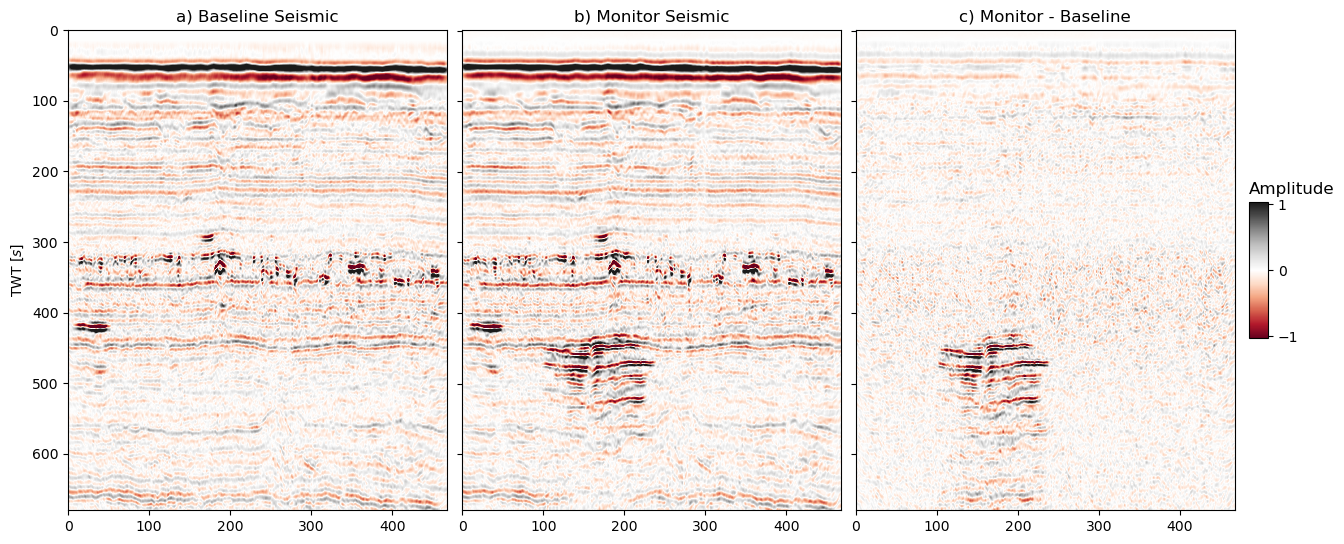

In [5]:
plotter_4D(b, m, type='seismic', dt=1., height=6, cmap='RdGy', perc=1)
# plt.savefig('../../figures/Sleipner_seismic_94_01.png', bbox_inches='tight')

## L2 - INVERSION

In [10]:
alpha = 0.1
id = Identity(int(nx * nt), int(nx * nt))
ID = HStack([-id * alpha, id * alpha])
LOP = BlockDiag([Lop_base, Lop_mon])
LOP2 = VStack([LOP, ID])
Dop = Laplacian(dims=(nt, nx), dtype=Lop_base.dtype)
DOP = BlockDiag([Dop, Dop])
MBACK = np.hstack([mback.ravel(), mback.ravel()])
D_L2 = np.hstack([b.ravel(), m.ravel(), np.zeros(nt * nx)])

# L2 regularized inversion
imp_L2 = RegularizedInversion(LOP2, D_L2, [DOP],
                              x0=MBACK, epsRs=[1.5], show=False,
                              **dict(iter_lim=100))[0]

imp_L2b = np.exp(imp_L2[:imp_L2.shape[0] // 2].reshape(nt, nx))
imp_L2m = np.exp(imp_L2[imp_L2.shape[0] // 2:].reshape(nt, nx))
dif_L2 = (imp_L2m - imp_L2b) / imp_L2m  # difference as percentage

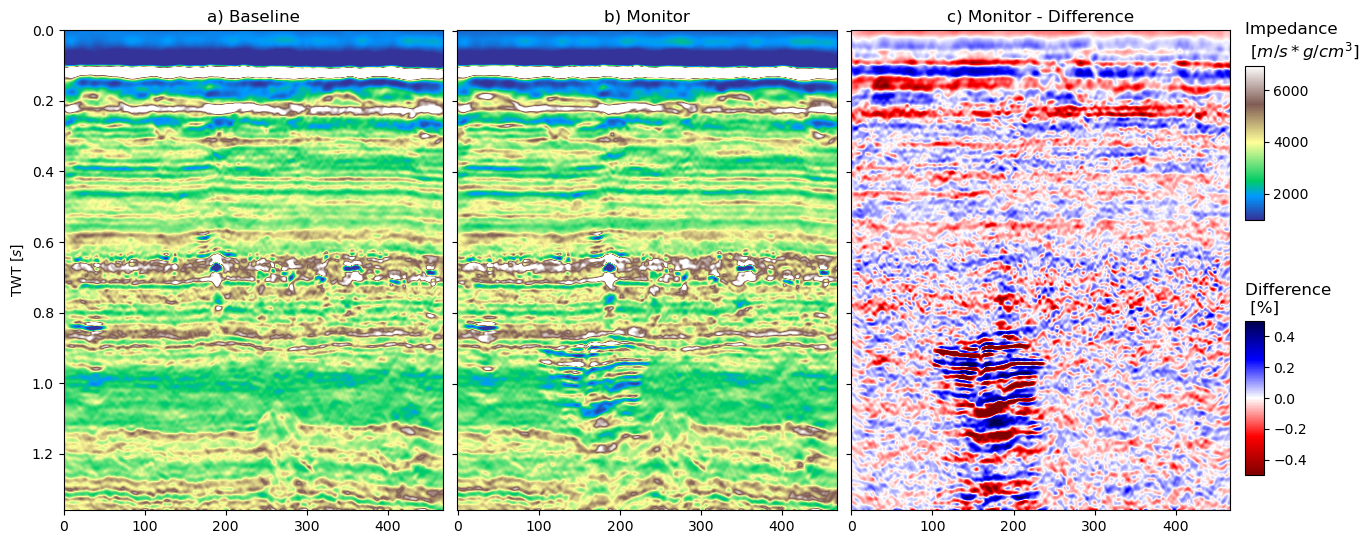

In [11]:
plotter_4D(imp_L2b, imp_L2m, type='impedance', perc=3, dif_scale=0.5, dt=dt, height=6)
# plt.savefig('../../figures/Sleipner_l2inv_94_01.png', bbox_inches='tight')

## TV - INVERSION

In [15]:
LOP = BlockDiag([Lop_base, Lop_mon])
D_TV = np.hstack([b.ravel(), m.ravel()])
MBACK = np.hstack([mback.ravel(), mback.ravel()])
l2_2 = L2(Op=LOP, b=D_TV, niter=20, warm=True)
Dzop = FirstDerivative(dims=(nt, nx), axis=0, edge=True, dtype=Lop_base.dtype, kind='forward')
Dxop = FirstDerivative(dims=(nt, nx), axis=1, edge=True, dtype=Lop_base.dtype, kind='forward')
Zop = Zero(nx * nt, dtype='float64')
sigma = 0.1
alpha = 1.
DOP = Block([[Dzop, Zop],
             [Zop, Dzop],
             [alpha * Dzop, -alpha * Dzop],
             [Dxop, Zop],
             [Zop, Dxop],
             [alpha * Dxop, -alpha * Dxop]])
l21 = L21(ndim=2, sigma=sigma)

L = 18.  # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 / (tau * L)
imp_TV = PrimalDual(l2_2, l21, DOP, MBACK, tau=tau, mu=mu,
                    theta=1., niter=100, show=True)

imp_TVb = np.exp(imp_TV[:imp_TV.shape[0] // 2].reshape(nt, nx))
imp_TVm = np.exp(imp_TV[imp_TV.shape[0] // 2:].reshape(nt, nx))
dif_TV = (imp_TVm - imp_TVb) / imp_TVm  # difference as percentage

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.block.Block'>
Additional vector (z): None
tau = 1.0		mu = 0.055
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   7.31294e+00   7.091e+03   4.565e+03   0.000e+00       1.166e+04
     2   7.31340e+00   3.817e+03   6.013e+03   0.000e+00       9.830e+03
     3   7.31398e+00   2.795e+03   6.417e+03   0.000e+00       9.212e+03
     4   7.31422e+00   2.355e+03   6.433e+03   0.000e+00       8.788e+03
     5   7.31387e+00   2.131e+03   6.301e+03   0.000e+00       8.432e+03
     6   7.31281e+00   2.010e+03   6.118e+03   0.000e+00       8.128e+03
     7   7.31106e+00   1.944e+03   5.929e+03   0.000e+00       7.873e+03
     8   7.30867e+00   1.910e+03   5.753e+03   0.000e

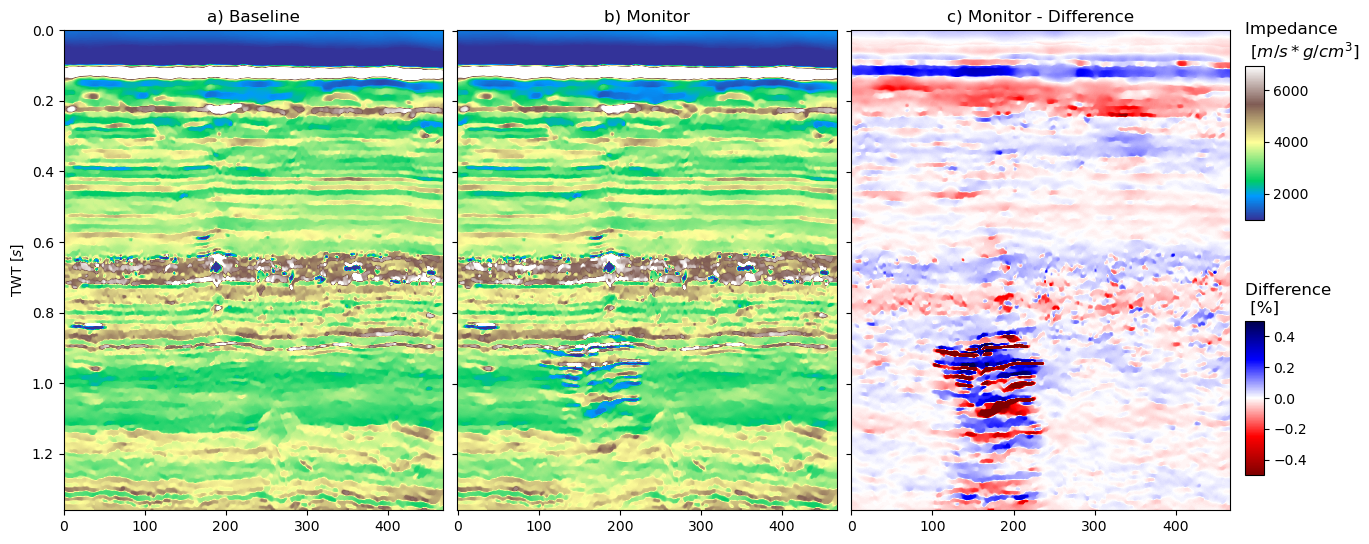

In [16]:
plotter_4D(imp_TVb, imp_TVm, type='impedance', perc=3, dif_scale=0.5, dt=dt, height=6, ref=imp_L2b)
# plt.savefig('../../figures/Sleipner_TVinv_94_01.png', bbox_inches='tight')

Working with alpha=0.200000,  beta=2.000000,  delta=5.000000
Iteration 0...
f= 2531.106580538233
||v-v_old||_2= 560.4841994067541
||m-m_old||_2= 305.34176385219496
Iteration 1...
f= 1911.845208515548
||v-v_old||_2= 25.15346287869602
||m-m_old||_2= 113.74231522976162


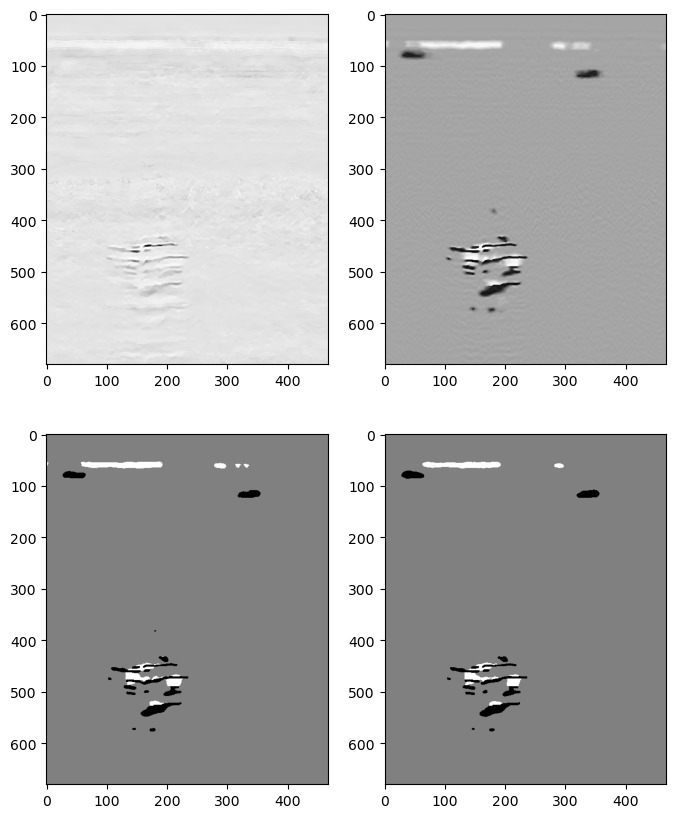

In [17]:
cl = np.array([-.5, 0., .5])
alpha = 0.2
# alpha = 0.5
alpha_dif = 0.
beta = 2.
delta = 5.

niter = 2
tolstop = 0.

L = 18.  # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 / (tau * L)
model_TV = 'isotropic'

mjoint, vjoint, vcljoint, rre_, psnr_, mjoint_hist, vjoint_hist = jis_4D(b, m, mback, cl,
                                                                         Lop_base, Lop_mon,
                                                                         model_TV,
                                                                         alpha,
                                                                         beta, delta, tau, mu,
                                                                         niter=niter,
                                                                         l2niter=20,
                                                                         pdniter=100,
                                                                         segmentniter=40,
                                                                         bisectniter=10,
                                                                         tolstop=tolstop,
                                                                         plotflag=True,
                                                                         show=False)

imp_jointb = np.exp(mjoint[:mjoint.shape[0] // 2].reshape(nt, nx))
imp_jointm = np.exp(mjoint[mjoint.shape[0] // 2:].reshape(nt, nx))

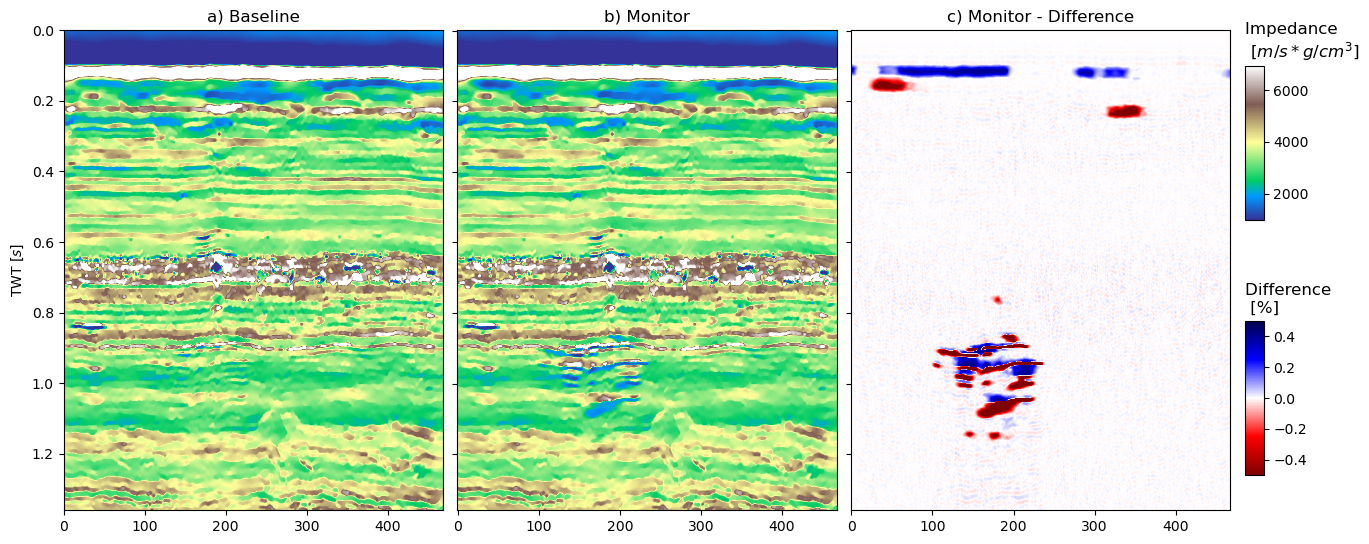

In [18]:
plotter_4D(imp_jointb, imp_jointm, type='impedance', perc=3, dif_scale=0.5, dt=dt, height=6, ref=imp_L2b)
# plt.savefig('../../figures/Sleipner_JIS_94_01.png', bbox_inches='tight')

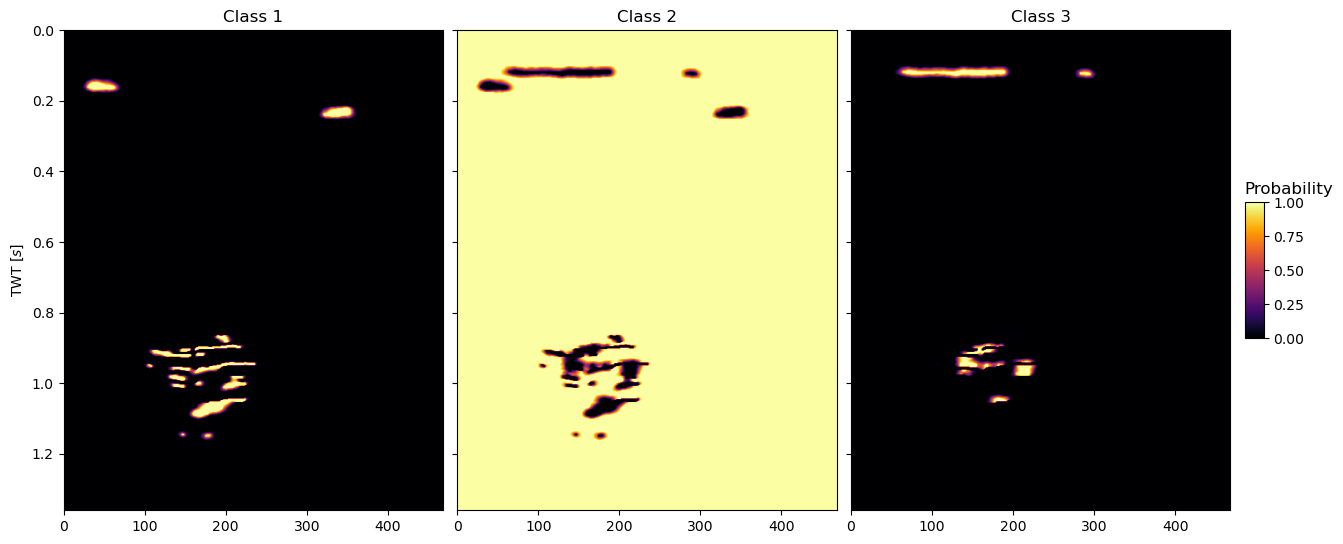

In [19]:
plotter_4D_seg(vjoint, nt, nx, dt, height=6)